In [0]:
import cv2
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import PIL.Image
import torch
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
!git clone https://github.com/brian-yu/cs4501-cv.git

Cloning into 'cs4501-cv'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 3695 (delta 1), reused 313 (delta 1), pack-reused 3380
Receiving objects: 100% (3695/3695), 304.05 MiB | 36.11 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [3]:
!cd cs4501-cv && git pull

Already up to date.


In [4]:
!ls cs4501-cv

board_images				     README.md
corner_samples				     requirements.txt
crop_board.py				     samples
extract_track_images_from_corner_samples.py  score_board.py
extract_track_images.py			     score_corner_sample.py
find_track_positions.py			     ticket_to_ride_model.pt
label_corners.py			     tracks.p
label_track_images.py


In [0]:
class TicketToRideDataset(Dataset):

    def __init__(self, data_dir='cs4501-cv/samples', transform=None):
        self.transform = transform
        self.label_names = ["red", "green", "blue", "black", "yellow", "none"]
        self.name_labels = {label: idx for idx, label in enumerate(self.label_names)}
        self.data_dir = data_dir

        self.image_files = []
        self.read_files()
    
    def read_files(self):
      for fname in os.listdir(self.data_dir):
        label = fname.split("-")[0]
        if label in self.label_names:
          self.image_files.append(fname)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_file)

        image = PIL.Image.open(img_path)
        label = self.name_labels[img_file.split("-")[0]]

        if self.transform:
            image = self.transform(image)

        return image, label

In [0]:
preprocess = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

dataset = TicketToRideDataset(transform=preprocess)

train_length = int(.8 * len(dataset))
val_length = len(dataset) - train_length
train_dataset, val_dataset = torch.utils.data.random_split(dataset, (train_length, val_length))

In [7]:
print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Total dataset size: 3090
Train dataset size: 2472
Validation dataset size: 618


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    start = time.time()

    history = {
        "loss": {
            "train": [],
            "val": []
        },
        "acc": {
            "train": [],
            "val": []
        }
    }

    for epoch in range(num_epochs):
        print('Epoch {} out of {}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            dataloader = dataloaders[phase]

            for x, y in dataloader:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)

                    _, pred = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * x.size(0)
                running_corrects += torch.sum(pred == y.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            history['loss'][phase].append(epoch_loss)
            history['acc'][phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    epoch_time = time.time() - start
    print(f'Finished in {(epoch_time // 60):.0f}m {(epoch_time % 60):.0f}s')

    return model, history

In [0]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [10]:
dataloaders_dict = {
    "train": train_loader,
    "val": val_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
from collections import OrderedDict

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 6)
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs,100)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(.2)),
    ('fc2', nn.Linear(100,6)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.fc = fc

model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0 out of 9
train Loss: 1.2877 Acc: 0.5222
val Loss: 0.5515 Acc: 0.9078

Epoch 1 out of 9
train Loss: 0.3218 Acc: 0.9377
val Loss: 0.1164 Acc: 0.9822

Epoch 2 out of 9
train Loss: 0.1229 Acc: 0.9737
val Loss: 0.0533 Acc: 0.9951

Epoch 3 out of 9
train Loss: 0.0747 Acc: 0.9834
val Loss: 0.0333 Acc: 0.9935

Epoch 4 out of 9
train Loss: 0.0586 Acc: 0.9879
val Loss: 0.0299 Acc: 0.9951

Epoch 5 out of 9
train Loss: 0.0463 Acc: 0.9915
val Loss: 0.0264 Acc: 0.9951

Epoch 6 out of 9
train Loss: 0.0311 Acc: 0.9951
val Loss: 0.0278 Acc: 0.9935

Epoch 7 out of 9
train Loss: 0.0209 Acc: 0.9968
val Loss: 0.0158 Acc: 0.9968

Epoch 8 out of 9
train Loss: 0.0211 Acc: 0.9951
val Loss: 0.0191 Acc: 0.9951

Epoch 9 out of 9
train Loss: 0.0154 Acc: 0.9976
val Loss: 0.0244 Acc: 0.9919

Finished in 2m 46s


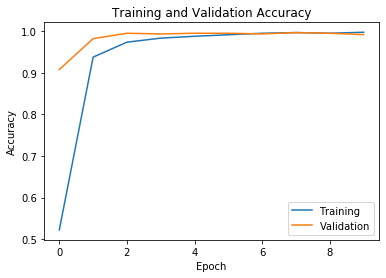

In [13]:
plt.plot(hist['acc']['train'], label="Training")
plt.plot(hist['acc']['val'], label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig('accuracy.png', dpi=1000)
plt.show()

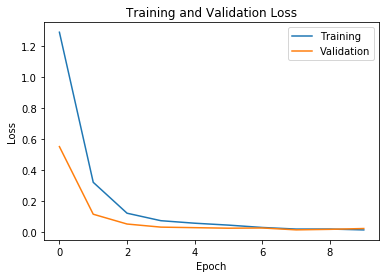

In [14]:
plt.plot(hist['loss']['train'], label="Training")
plt.plot(hist['loss']['val'], label="Validation")
plt.title("Training and Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('loss.png', dpi=1000)
plt.show()

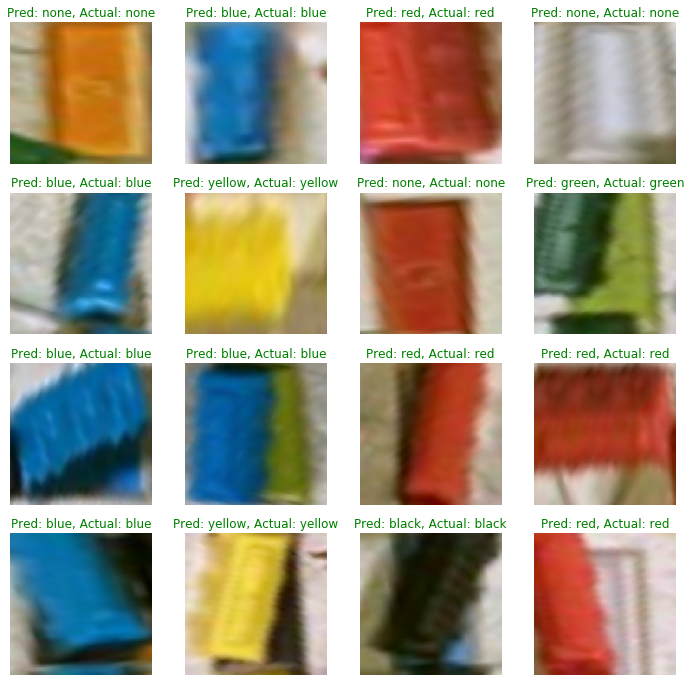

In [15]:
from random import randint

def predict(image, classifier):
  input_img = image.to(device)
  predictions = classifier(input_img)

  return torch.argmax(predictions[0])

def untransform_image(image):
  inv_normalize = transforms.Normalize(
          mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
          std=[1/0.229, 1/0.224, 1/0.255]
      )
  return inv_normalize(image[0]).clamp(0, 1).permute(1,2,0)

def predict_images(val_data_loader, classifier):

  classifier.eval()

  predictions = []

  NUM_PRED = 16

  for _ in range(NUM_PRED):
    entry = next(iter(val_data_loader))
    image, label = entry

    pred = predict(image, classifier)

    pred_class = val_data_loader.dataset.dataset.label_names[pred]
    actual_class = val_data_loader.dataset.dataset.label_names[label[0]]
    
    inv_image = untransform_image(image)

    predictions.append((inv_image, pred_class, actual_class))
  
  n_row = 4
  n_col = 4
  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for i, ax in zip(range(NUM_PRED), axs):
      img, pred_class, actual_class = predictions[i]

      color = "green" if pred_class == actual_class else "red"

      ax.imshow(img)
      ax.grid('off')
      ax.axis('off')
      ax.set_title(f'Pred: {pred_class}, Actual: {actual_class}', {'color': color})
  plt.savefig('predictions.png', dpi=1000)
  plt.show()

predict_images(val_loader, model)

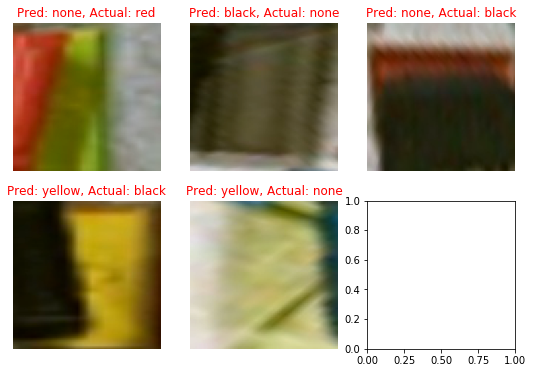

In [16]:
# incorrect predictions
incorrect_imgs = []
for image, label in val_dataset:
  pred = predict(image.unsqueeze(0), model).item()

  pred_class = val_loader.dataset.dataset.label_names[pred]
  actual_class = val_loader.dataset.dataset.label_names[label]

  transform = transforms.Compose([
    transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
      std=[1/0.229, 1/0.224, 1/0.255]
    )])
  inv_image = transform(image).clamp(0, 1).permute(1,2,0)

  if pred != label:
    incorrect_imgs.append([inv_image, pred_class, actual_class])

n_row = 2
n_col = 3
_, axs = plt.subplots(n_row, n_col, figsize=(9, 6))
axs = axs.flatten()
# for img, pred_class, actual_class in incorrect_imgs:
  
for i, ax in zip(range(len(incorrect_imgs)), axs):
  img, pred_class, actual_class = incorrect_imgs[i]

  color = "green" if pred_class == actual_class else "red"

  ax.imshow(img)
  ax.grid('off')
  ax.axis('off')
  ax.set_title(f'Pred: {pred_class}, Actual: {actual_class}', {'color': color})
plt.savefig('incorrect.png', dpi=1000)
plt.show()

In [0]:
torch.save(model.state_dict(), "ticket_to_ride_model.pt")

In [0]:
from google.colab import files

files.download("ticket_to_ride_model.pt")
files.download("accuracy.png")
files.download('loss.png')
files.download('predictions.png')
files.download('incorrect.png')